In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import gpjax as gpx
import jax 
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np
import scienceplots

from gpkan.gpKAN import GPKAN
from test_functions import *
from sklearn.model_selection import train_test_split

plt.style.use([ "science", "grid" ])
plt.rcParams.update({'axes.titlesize': 18})
plt.rcParams.update({'axes.labelsize': 15})

jax.config.update("jax_enable_x64", True)
key = jr.key(123)
px = 1/plt.rcParams['figure.dpi']

/Users/aaron/Documents/masters/gaussian-process-kan/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


### Test function

In [2]:
f = lambda x, y: jnp.sin(x) ** 10 + jnp.cos(10 + y * x) * jnp.cos(x) + 5 # JVDP  

samples = 30
x1, x2 = jnp.meshgrid(jnp.linspace(0, 5, samples), jnp.linspace(0, 5, samples))
X = jnp.stack([x1.flatten(), x2.flatten()]).T
y = f(X[:, 0], X[:, 1]).reshape(-1, 1)
# y = jnp.log(f(X[:, 0], X[:, 1])).reshape(-1, 1)
# y = jnp.sqrt(f(X[:, 0], X[:, 1]).reshape(-1, 1))
print(min(y), max(y))
function_name = "trig"

[4.00665943] [6.05032996]


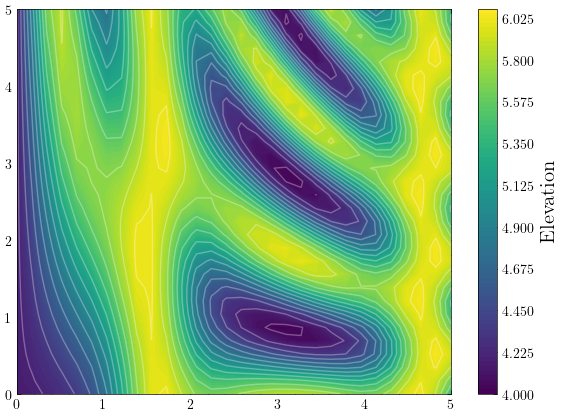

In [3]:
y_grid = y.reshape(samples, samples)
fig_data, ax_data = plt.subplots(figsize=(7, 5))
contour = ax_data.contour(x1, x2, y_grid, levels=15, colors="white", alpha=0.3)
countourf = ax_data.contourf(x1, x2, y_grid, levels=100)
cbar = fig_data.colorbar(countourf, ax=ax_data, label="Elevation")
plt.show()

## Modelling

In [4]:
model_size = [2, 10, 10, 1]
model_str = '-'.join(str(x) for x in model_size)
model = GPKAN(layers=model_size,
              n_grid_points=10, 
              grid_min=jnp.min(X), 
              grid_max=jnp.max(X), 
              init_paramters=[1.0, 1.0], 
              obs_stddev=0.5
              )

Model initialized.


### Training

In [5]:
def loss_ll(y_true, mean, covariance):
    diag_elements = jnp.diag(covariance)
    covariance_inv = jnp.diag(1.0 / diag_elements)
    log_det = jnp.sum(jnp.log(diag_elements))
    y_true = y_true.flatten()

    return -(-0.5 * (
        y_true.shape[0] * jnp.log(2 * jnp.pi) + 
        log_det + 
        (y_true - mean).T @ covariance_inv @ (y_true - mean)))

In [6]:
def get_learning_rate(epoch, initial_lr=0.0001):
    return initial_lr * (0.95 ** (epoch//50))
get_learning_rate = jax.jit(get_learning_rate)

def clip_gradients(grads, max_norm=1.0):
    grad_norm = jnp.sqrt(sum(jnp.sum(g**2) for g in jax.tree.leaves(grads)))
    clip_factor = jnp.minimum(1.0, max_norm / grad_norm)
    return jax.tree.map(lambda g: g * clip_factor, grads)
clip_gradients = jax.jit(clip_gradients)

In [7]:
val_grad_loss = jax.value_and_grad(
    lambda Xs_latent, ys_latent, kernel_params, X_test, y_test:
        loss_ll(y_test,
                *model.sample_statistics(Xs_latent, ys_latent, X_test, kernel_params, n_samples=10)
                ),
                argnums=(0, 1, 2)
)
val_grad_loss = jax.jit(val_grad_loss)

### Batch-wise training

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=321)

### Optimizing latent support and kernel parameters individually

In [9]:
epochs = 500
learning_rate = 0.001
loss_history = []

batch_size = 32
patience = 100  # Number of epochs to wait for improvement
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    epoch_losses = []
    current_lr = get_learning_rate(epoch, initial_lr=learning_rate)

    for i in range(0, X_train.shape[0], batch_size):
        batch_X = X_train[i:i+batch_size, :]
        batch_y = y_train[i:i+batch_size, :]

        loss, (grad_grids, grad_supports, grad_params) = val_grad_loss(
            model.latent_grids, 
            model.latent_supports,
            model.kernel_parameters,
            batch_X, batch_y
            )
        
        # Stop training if loss becomes negative
        if loss < 0 or jnp.isnan(loss):
            print(f"Stopping training at epoch {epoch} as loss became negative: {loss}")
            break 

        # grad_supports = clip_gradients(grad_supports)

        model.latent_supports = jax.tree.map(
            lambda latent_supports, grad_supports_: 
            latent_supports - grad_supports_ * current_lr,
            model.latent_supports,
            grad_supports
        )
        model.latent_grids = jax.tree.map(
            lambda latent_grids, grad_grids_: 
            latent_grids - grad_grids_ * current_lr,
            model.latent_grids,
            grad_grids
        )

        epoch_losses.append(loss)

    # Check for improvement
    epoch_loss = np.mean(epoch_losses)
    if loss < best_loss:
        best_loss = loss
        patience_counter = 0 
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}, best loss: {best_loss}")
        break

    loss_history.append(epoch_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss: {epoch_loss:.6f}, LR: {current_lr:.6f}")
    loss_history.append(loss)

/Users/aaron/Documents/masters/gaussian-process-kan/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/Users/aaron/Documents/masters/gaussian-process-kan/.venv/lib/python3.12/site-packages/cola/backends/backends.py:75: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
2025-06-09 15:05:15.334482: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-06-09 15:12:50.962148: E ext

Epoch 0: Loss: 133.707425, LR: 0.001000
Epoch 10: Loss: 73.394914, LR: 0.001000
Epoch 20: Loss: 63.709478, LR: 0.001000
Epoch 30: Loss: 60.855999, LR: 0.001000
Epoch 40: Loss: 59.219257, LR: 0.001000
Epoch 50: Loss: 57.903426, LR: 0.000950
Epoch 60: Loss: 56.802382, LR: 0.000950
Epoch 70: Loss: 55.813797, LR: 0.000950
Epoch 80: Loss: 54.922245, LR: 0.000950
Epoch 90: Loss: 54.106097, LR: 0.000950
Epoch 100: Loss: 53.348066, LR: 0.000902
Epoch 110: Loss: 52.674169, LR: 0.000902
Epoch 120: Loss: 52.045505, LR: 0.000902
Epoch 130: Loss: 51.461626, LR: 0.000902
Epoch 140: Loss: 50.921120, LR: 0.000902
Epoch 150: Loss: 50.420782, LR: 0.000857
Epoch 160: Loss: 49.976179, LR: 0.000857
Epoch 170: Loss: 49.548197, LR: 0.000857
Epoch 180: Loss: 49.192248, LR: 0.000857
Epoch 190: Loss: 48.751976, LR: 0.000857
Epoch 200: Loss: 48.509679, LR: 0.000815
Epoch 210: Loss: 48.155844, LR: 0.000815
Epoch 220: Loss: 47.843736, LR: 0.000815
Epoch 230: Loss: 47.573241, LR: 0.000815
Epoch 240: Loss: 47.391170

In [10]:
# learning_rate = 0.01
loss_history_params = []

batch_size = 32
patience = 100  # Number of epochs to wait for improvement
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    epoch_losses_params = []
    current_lr = get_learning_rate(epoch, initial_lr=learning_rate)

    for i in range(0, X_train.shape[0], batch_size):
        batch_X = X_train[i:i+batch_size, :]
        batch_y = y_train[i:i+batch_size, :]

        loss, (grad_grids, grad_supports, grad_params) = val_grad_loss(
            model.latent_grids, 
            model.latent_supports,
            model.kernel_parameters,
            batch_X, batch_y
            )
        
        # Stop training if loss becomes negative
        if loss < 0 or jnp.isnan(loss):
            print(f"Stopping training at epoch {epoch} as loss became negative: {loss}")
            break 

        grad_params = clip_gradients(grad_params)

        model.kernel_parameters = jax.tree.map(
            lambda kernel_params, grad_params_:
            kernel_params - grad_params_ * current_lr,
            model.kernel_parameters,
            grad_params 
        )

        epoch_losses_params.append(loss)

    # Check for improvement
    epoch_loss_params = np.mean(epoch_losses_params)
    if loss < best_loss:
        best_loss = loss
        patience_counter = 0 
    else:
        patience_counter += 1
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}, best loss: {best_loss}")
        break

    loss_history_params.append(epoch_loss_params)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss: {epoch_loss_params:.6f}, LR: {current_lr:.6f}")
    loss_history.append(loss)

2025-06-09 16:01:48.818046: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 9m38.562815s

********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-06-09 16:04:15.439945: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-06-09 16:11:14.415876: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 8m58.978794s

********************************
[Compiling module jit__lambda_] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Epoch 0: Loss: 42.609797, LR: 0.001000
Epoch 10: Loss: 41.560883, LR: 0.001000
Epoch 20: Loss: 40.800933, LR: 0.001000
Epoch 30: Loss: 40.212781, LR: 0.001000
Epoch 40: Loss: 39.750377, LR: 0.001000
Epoch 50: Loss: 39.376733, LR: 0.000950
Epoch 60: Loss: 39.079134, LR: 0.000950
Epoch 70: Loss: 38.821722, LR: 0.000950
Epoch 80: Loss: 38.593925, LR: 0.000950
Epoch 90: Loss: 38.388649, LR: 0.000950
Epoch 100: Loss: 38.200900, LR: 0.000902
Epoch 110: Loss: 38.035954, LR: 0.000902
Epoch 120: Loss: 37.881822, LR: 0.000902
Epoch 130: Loss: 37.736880, LR: 0.000902
Epoch 140: Loss: 37.599847, LR: 0.000902
Epoch 150: Loss: 37.469421, LR: 0.000857
Epoch 160: Loss: 37.351310, LR: 0.000857
Epoch 170: Loss: 37.238001, LR: 0.000857
Epoch 180: Loss: 37.128950, LR: 0.000857
Epoch 190: Loss: 37.023689, LR: 0.000857
Epoch 200: Loss: 36.921513, LR: 0.000815
Epoch 210: Loss: 36.827515, LR: 0.000815
Epoch 220: Loss: 36.735983, LR: 0.000815
Epoch 230: Loss: 36.646671, LR: 0.000815
Epoch 240: Loss: 36.559362,

### Prediction

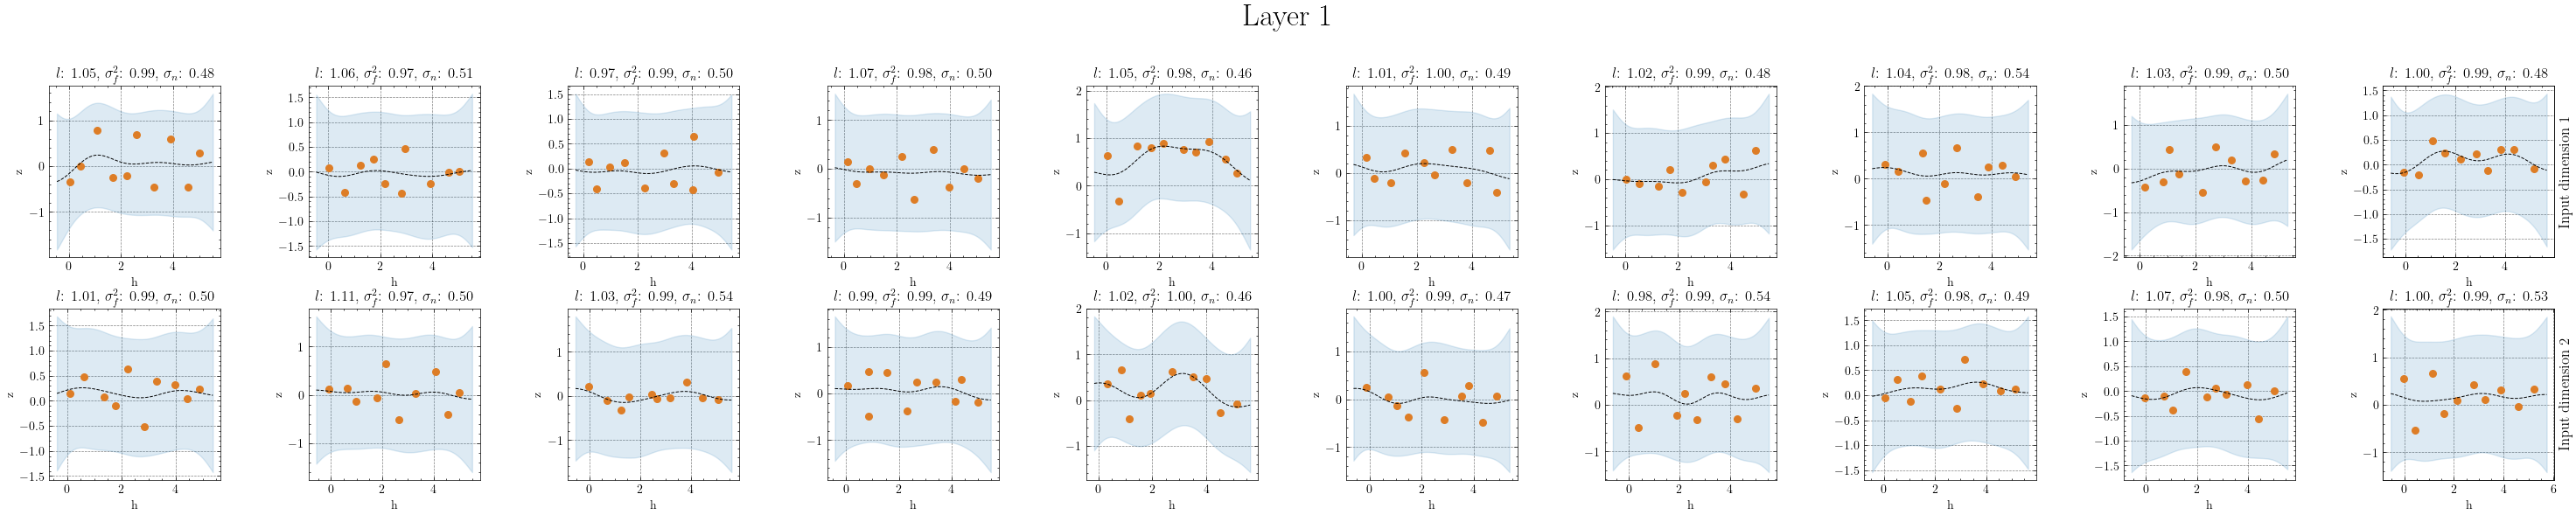

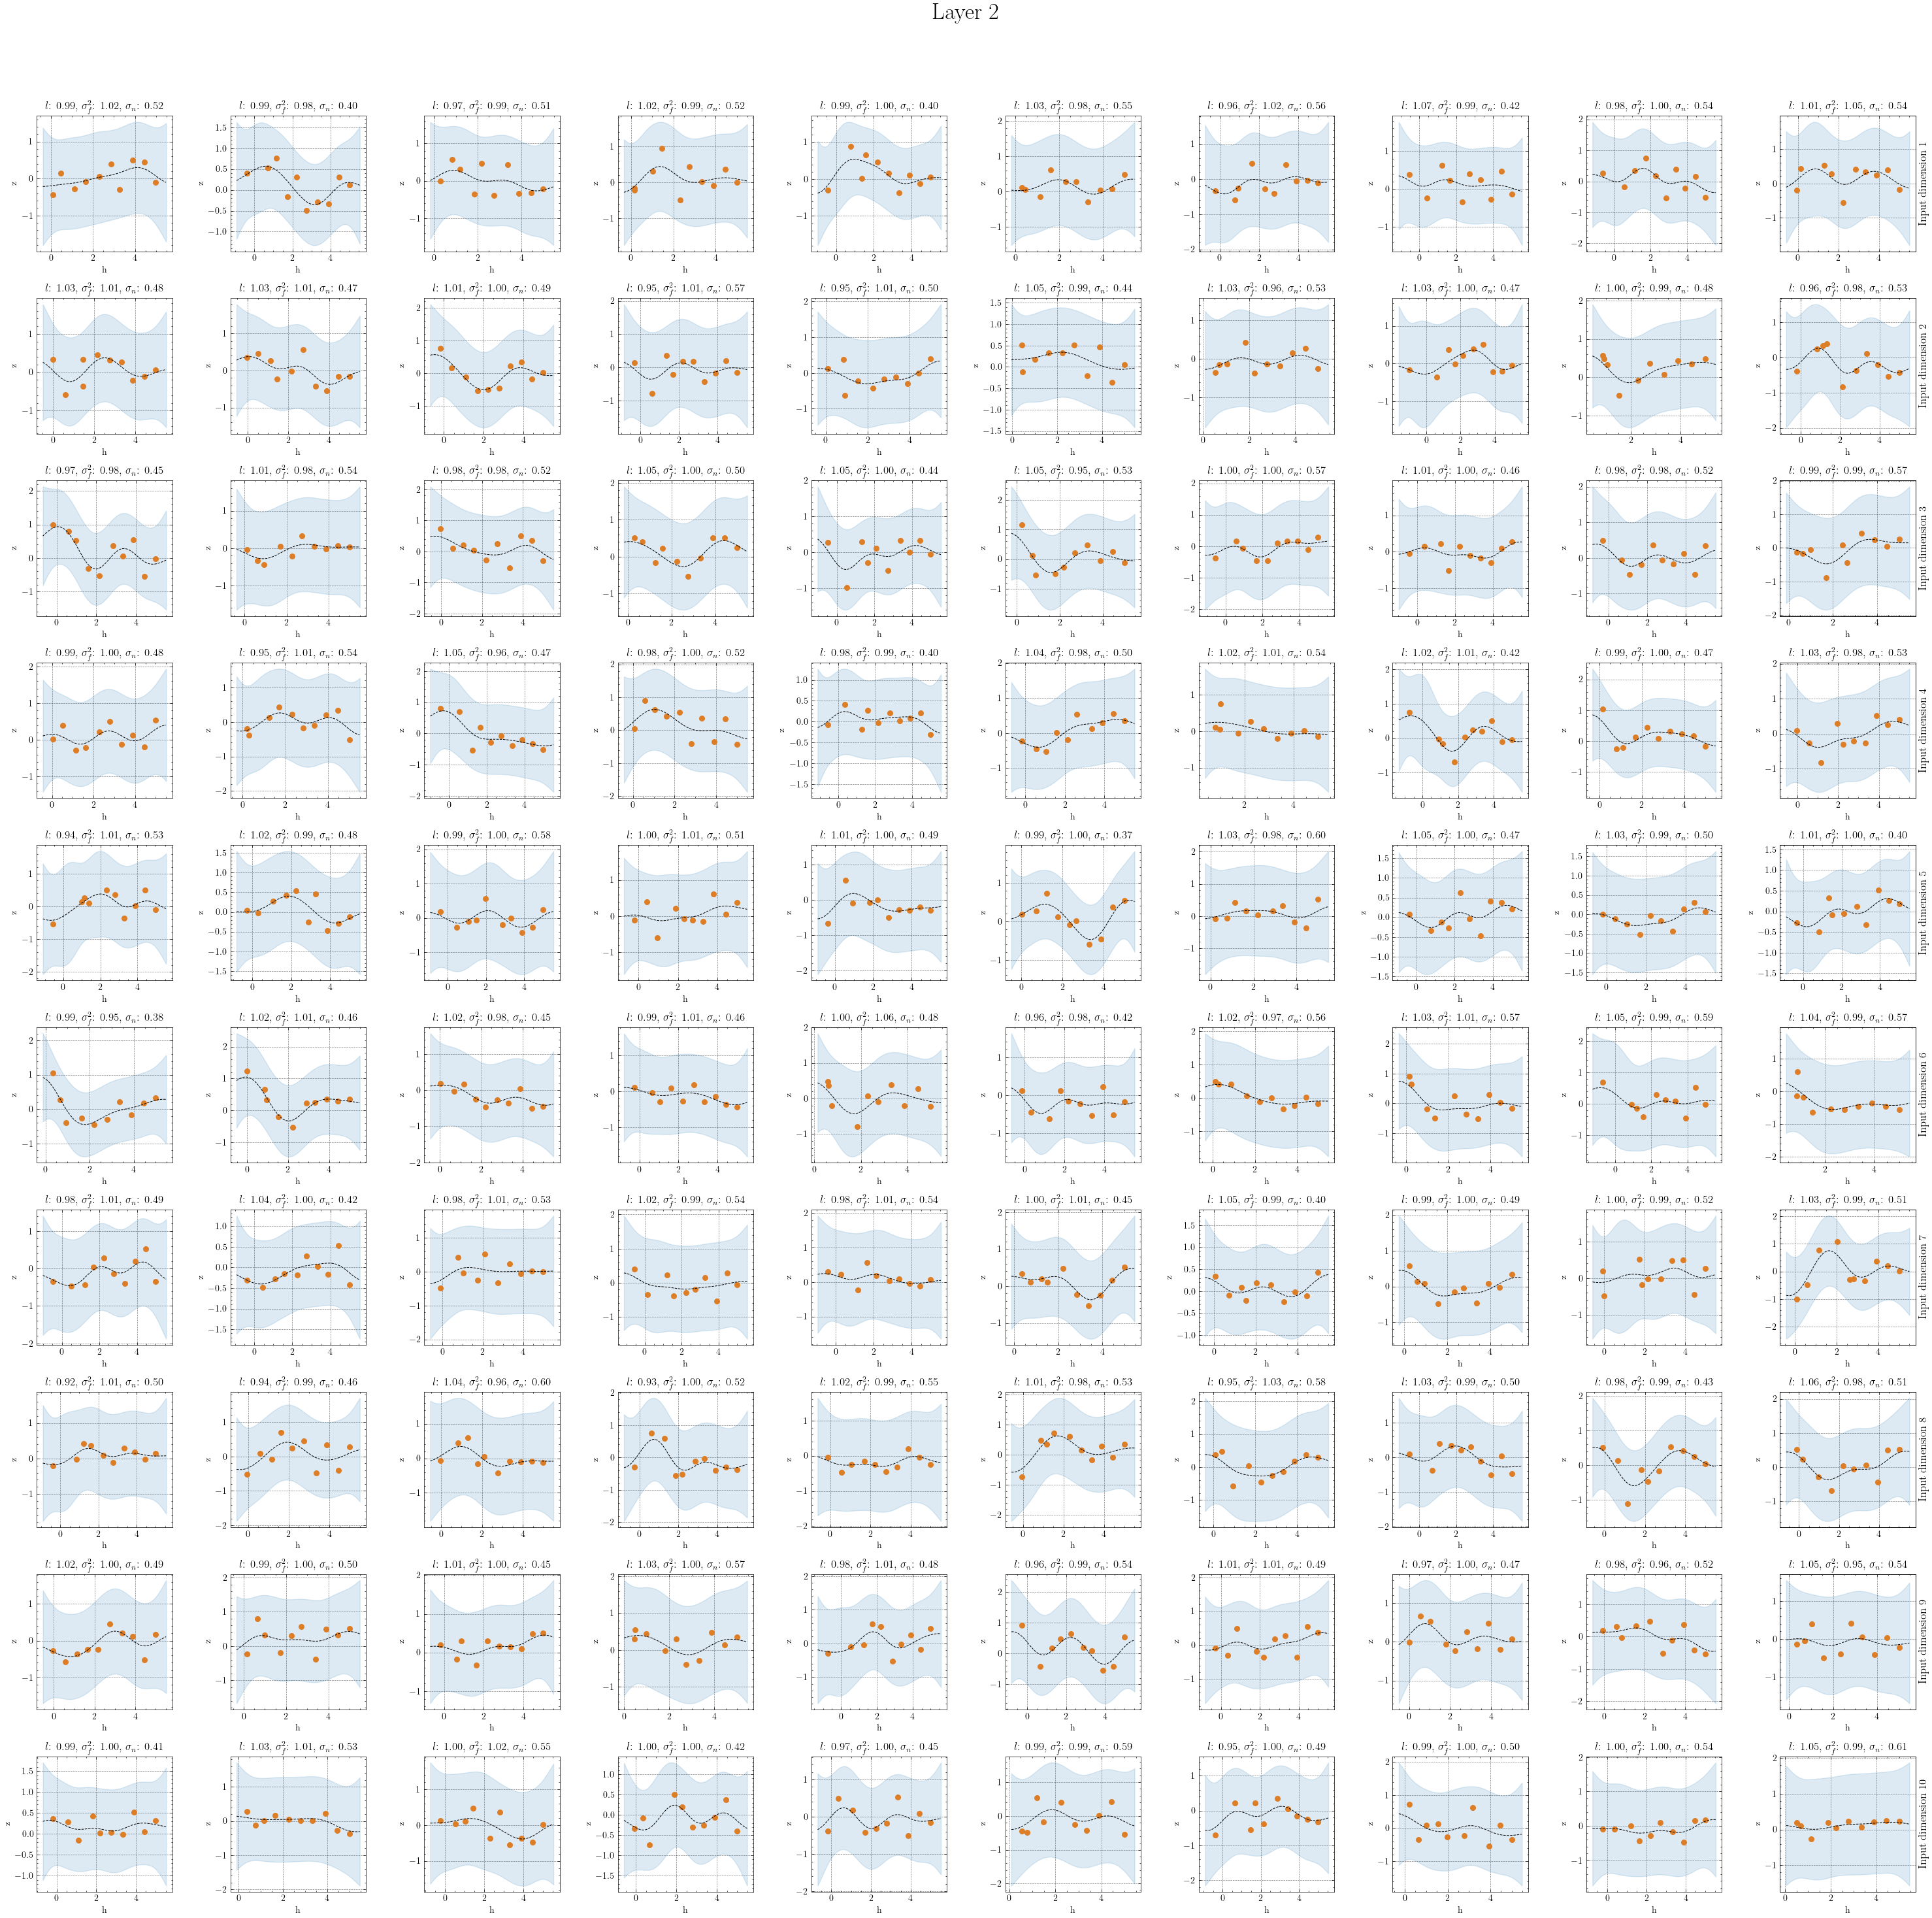

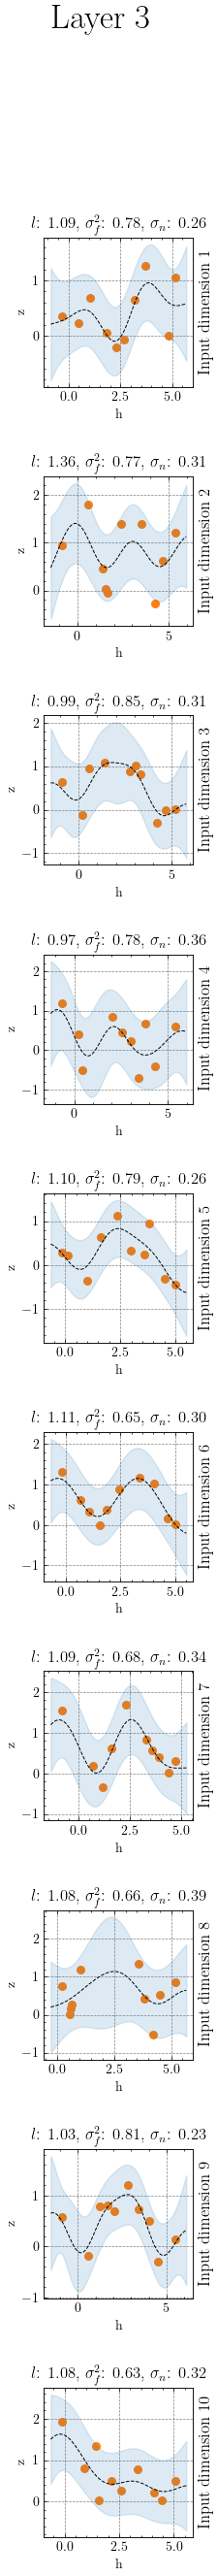

In [11]:
model.plot_neurons(
    # save_fig=True,
                   save_path=f"../results/{function_name}/figs/{function_name+" "+model_str}")

In [12]:
batch_size = 32 # Adjust as needed
n = X.shape[0]
mu_batches = []
cov_blocks = []

progress_interval = int(n * 0.05)
for i in range(0, n, batch_size):
    X_batch = X[i:i+batch_size]
    mu_batch, cov_batch = model.sample_statistics(
        model.latent_grids, model.latent_supports, X_batch, model.kernel_parameters, 10, key=jr.key(233 + i)
    )
    mu_batches.append(mu_batch)
    cov_blocks.append(cov_batch)
    if (i // batch_size) % (progress_interval // batch_size) == 0:
        percent = int(100 * i / n)
        print(f"{percent}% done predicting...")

mu_full = jnp.concatenate(mu_batches)
cov_full = jax.scipy.linalg.block_diag(*cov_blocks)
y_stddev = jnp.sqrt(jnp.diag(cov_full))

0% done predicting...
3% done predicting...
7% done predicting...
10% done predicting...
14% done predicting...
17% done predicting...
21% done predicting...
24% done predicting...
28% done predicting...
32% done predicting...
35% done predicting...
39% done predicting...
42% done predicting...
46% done predicting...
49% done predicting...
53% done predicting...
56% done predicting...
60% done predicting...
64% done predicting...
67% done predicting...
71% done predicting...
74% done predicting...
78% done predicting...
81% done predicting...
85% done predicting...
88% done predicting...
92% done predicting...
96% done predicting...
99% done predicting...


In [13]:
residuals = y.flatten() - mu_full.flatten()
y_stddev = jnp.sqrt(jnp.diag(cov_full))
# y_sample = jr.multivariate_normal(jr.key(2341), mu_full, cov_full, shape=(1, )).flatten()
rmse = jnp.sqrt(jnp.mean((y.flatten() - mu_full.flatten()) ** 2))
print("RMSE:", float(rmse))

RMSE: 0.8960588603079113


<>:102: SyntaxWarning: invalid escape sequence '\%'
<>:102: SyntaxWarning: invalid escape sequence '\%'
/var/folders/3z/fbv_cnz175v2v_9cqnh_3t5r0000gn/T/ipykernel_87508/1276411255.py:102: SyntaxWarning: invalid escape sequence '\%'
  cbar_row2.set_label('Relative Error (\%)')


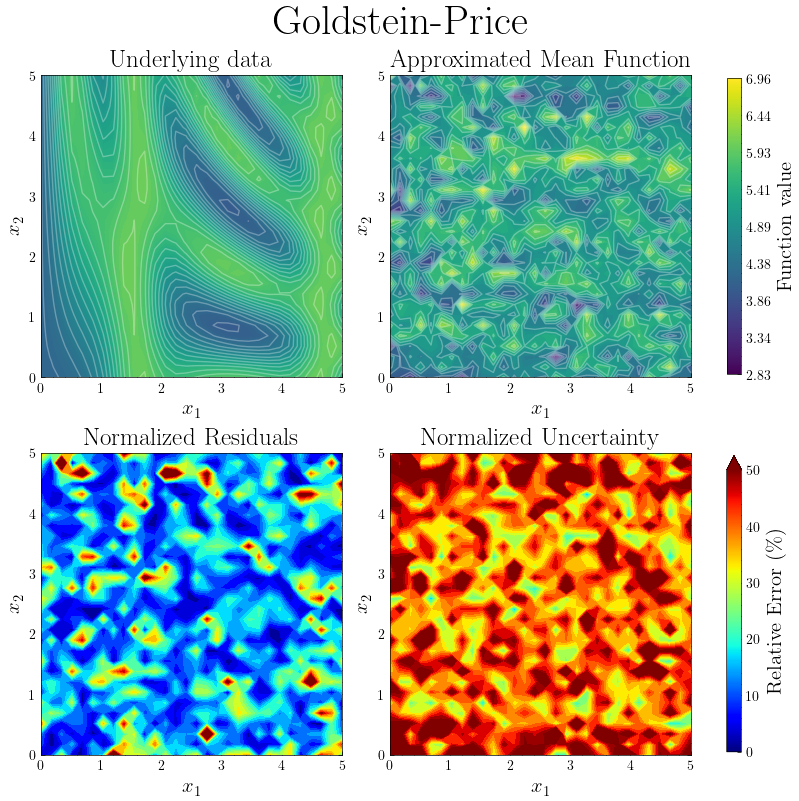

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True)
axs = axs.flatten()

# Determine the min/max values for the original function and mean
vmin = min(y.min(), mu_full.min())
vmax = max(y.max(), mu_full.max())
norm1 = plt.Normalize(vmin, vmax)
contour_level = 15

# First plot - Actual Function (unchanged)

contourf_test = axs[0].contourf(x1, x2, y.reshape(x2.shape[0], x1.shape[0]), 
                                levels=50,
                                cmap="viridis",
                                vmin=vmin,
                                vmax=vmax
                                )
axs[0].contour(x1, x2, y.reshape(x2.shape[0], x1.shape[0]), 
                                levels=contour_level,
                                colors="white",
                                alpha=.3
                                )

axs[0].set_title("Underlying data")
axs[0].set_xlabel("$x_1$")
axs[0].set_ylabel("$x_2$")

contourf_pred = axs[1].contourf(x1, x2, mu_full.reshape(x2.shape[0], x1.shape[0]), 
                                cmap="viridis",
                                levels=50,
                                vmin=vmin,
                                vmax=vmax
                                )
axs[1].contour(x1, x2, mu_full.reshape(x2.shape[0], x1.shape[0]), 
                                levels=contour_level,
                                colors="white",
                                alpha=.3
                                )
                                
axs[1].set_title("Approximated Mean Function")
axs[1].set_xlabel("$x_1$")
axs[1].set_ylabel("$x_2$")

from matplotlib.cm import ScalarMappable
import numpy as np
sm1 = ScalarMappable(cmap="viridis", norm=norm1)
sm1.set_array([])  # Empty array - using the norm instead
cbar_row1 = fig.colorbar(sm1, ax=[axs[0], axs[1]], location='right', shrink=0.98)
cbar_row1.set_label("Function value")

# Create evenly spaced ticks for the first colorbar
n_ticks = 9  # Number of ticks including min and max
ticks1 = np.linspace(vmin, vmax, n_ticks)
cbar_row1.set_ticks(ticks1)
cbar_row1.set_ticklabels([f"{tick:.2f}" for tick in ticks1])  # Format to 2 decimal places)  # Optional: ensure min/max are shown

# ----------------------------------------------------------------------------------------------------

# Third plot - Normalized Residuals (as percentage of mean)
reshaped_residuals = residuals.reshape(x2.shape[0], x1.shape[0])
epsilon = 1e-10
normalized_residuals = 100 * jnp.abs(reshaped_residuals.flatten()) / (jnp.abs(mu_full.flatten()) + epsilon)
normalizeddev = 100 * (y_stddev.flatten() / (jnp.abs(mu_full.flatten()) + epsilon))

vmin_2 = min(normalized_residuals.min(), normalizeddev.min())
vmax_2 = max(normalized_residuals.max(), normalizeddev.max())
cbar_limit = 50
levels = np.linspace(vmin_2, cbar_limit, 20)
# levels = np.arange(vmin_2, cbar_limit, 25)

contourf_res = axs[2].contourf(x1, x2, normalized_residuals.reshape(x2.shape[0], x1.shape[0]), 
                               levels=levels, 
                               cmap="jet",
                               vmin=vmin_2,
                               vmax=cbar_limit,
                               extend="max",
                               )

axs[2].set_title("Normalized Residuals")
axs[2].set_xlabel("$x_1$")
axs[2].set_ylabel("$x_2$")

contourf_var = axs[3].contourf(x1, x2, normalizeddev.reshape(x2.shape[0], x1.shape[0]), 
                                # levels=50, 
                                levels=levels,
                                cmap="jet",
                                vmin=vmin_2,
                                vmax=cbar_limit,
                                extend="max",
                                )
                                
axs[3].set_title("Normalized Uncertainty")
# axs[3].set_title("Coefficient of Variation")
axs[3].set_xlabel("$x_1$")
axs[3].set_ylabel("$x_2$")

# norm2 = plt.Normalize(vmin_2, vmax_2)  # Create explicit normalization
norm2 = plt.Normalize(vmin_2, cbar_limit)  # Create explicit normalization
sm2 = ScalarMappable(cmap="jet", norm=norm2)
sm2.set_array([])  # Empty array - using the norm instead
cbar_row2 = fig.colorbar(sm2, ax=[axs[2], axs[3]], location='right', shrink=0.98, extend="max")
cbar_row2.set_label('Relative Error (\%)')

# Create evenly spaced ticks for the first colorbar
n_ticks = 9 # Number of ticks including min and max
# ticks2 = np.linspace(vmin_2, vmax_2, n_ticks)
# ticks2 = np.linspace(vmin_2, cbar_limit, n_ticks)
# ticks2 = np.linspace(0, cbar_limit, n_ticks)
ticks2 = np.arange(0, cbar_limit + 1, 10)
cbar_row2.set_ticks(ticks2)
# cbar_row2.set_ticklabels([f"{tick:.1f}" for tick in ticks2])
cbar_row2.set_ticklabels([f"{tick}" for tick in ticks2])

fig.suptitle("Goldstein-Price", fontsize=30, fontweight="bold")

# plt.subplots_adjust(top=0.88)
plt.savefig(f"../results/{function_name}/figs/{function_name+" "+model_str}_result_grid_learned.png", dpi=500, bbox_inches="tight")
plt.show()